In [ ]:
pip install --force-reinstall --user scikit-learn==1.2.2

In [1]:
import joblib
import torch
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import pandas as pd
import os
import seaborn as sns
import shutil
import sklearn

In [2]:
sklearn.__version__

'1.2.2'

In [3]:
shutil.unpack_archive("model_and_scaler.zip", "model")

In [4]:
device = "cpu"
print(device)

cpu


In [5]:
n_samples = 410
n_input_G = 8

In [6]:
class Generator(nn.Module):
  def __init__(self, n_input, n_hidden_size, n_output=4, activation=nn.Tanh()):
    super(Generator, self).__init__()
    self.linear1 = nn.Linear(n_input, n_hidden_size)
    # Hack 4 : Use batch normalization : doesn't work
    self.batchnorm1 = nn.BatchNorm1d(n_hidden_size)
    self.relu1 = nn.LeakyReLU()
    # Hack 17 : Use dropout in both train and test
    self.dropout1 = nn.Dropout()
    self.linear2 = nn.Linear(n_hidden_size, n_output)
    # Hack 1 : Use tanh for the generator
    self.activation = activation

  def forward(self, x):
    x = self.linear1(x)
    x = self.relu1(x)
    x = self.dropout1(x)
    x = self.linear2(x)
    return self.activation(x)

In [7]:
model = torch.load("model/generator_model_distribution_shifting", map_location=device)

In [8]:
scaler = joblib.load('model/scaler.gz')

In [9]:
# torch.manual_seed(42)
# Noise generation
# noisy_input = Variable(torch.randn(n_samples, n_input_G)).to(device)
# # convert array into dataframe
# df = pd.DataFrame(noisy_input.cpu().numpy())
# # save the dataframe as a csv file
# df.to_csv("noisy_input.csv")

In [10]:
noisy_input = pd.read_csv("data/noisy_input.csv").drop(columns=["Unnamed: 0"]).values
noisy_input = torch.from_numpy(noisy_input).to(torch.float).to(device)

In [11]:
def infer_distribution_shifting(model, noisy_input, scaler):
  with torch.no_grad() :
    fakeData_shifting = model(noisy_input).cpu().numpy()
    fakeData_shifting = scaler.inverse_transform(fakeData_shifting)
  return fakeData_shifting

In [12]:
torch.manual_seed(42)
sample_results = infer_distribution_shifting(model, noisy_input, scaler)

In [13]:
sample_results

array([[0.00853745, 0.00919651, 0.00271734, 0.00549139],
       [0.00539262, 0.0104003 , 0.00733977, 0.00805275],
       [0.01278435, 0.00629123, 0.00980659, 0.01017363],
       ...,
       [0.04352811, 0.04262074, 0.01415627, 0.02850035],
       [0.01575143, 0.00898368, 0.00416616, 0.00829636],
       [0.0102424 , 0.00597908, 0.01009612, 0.01485654]], dtype=float32)

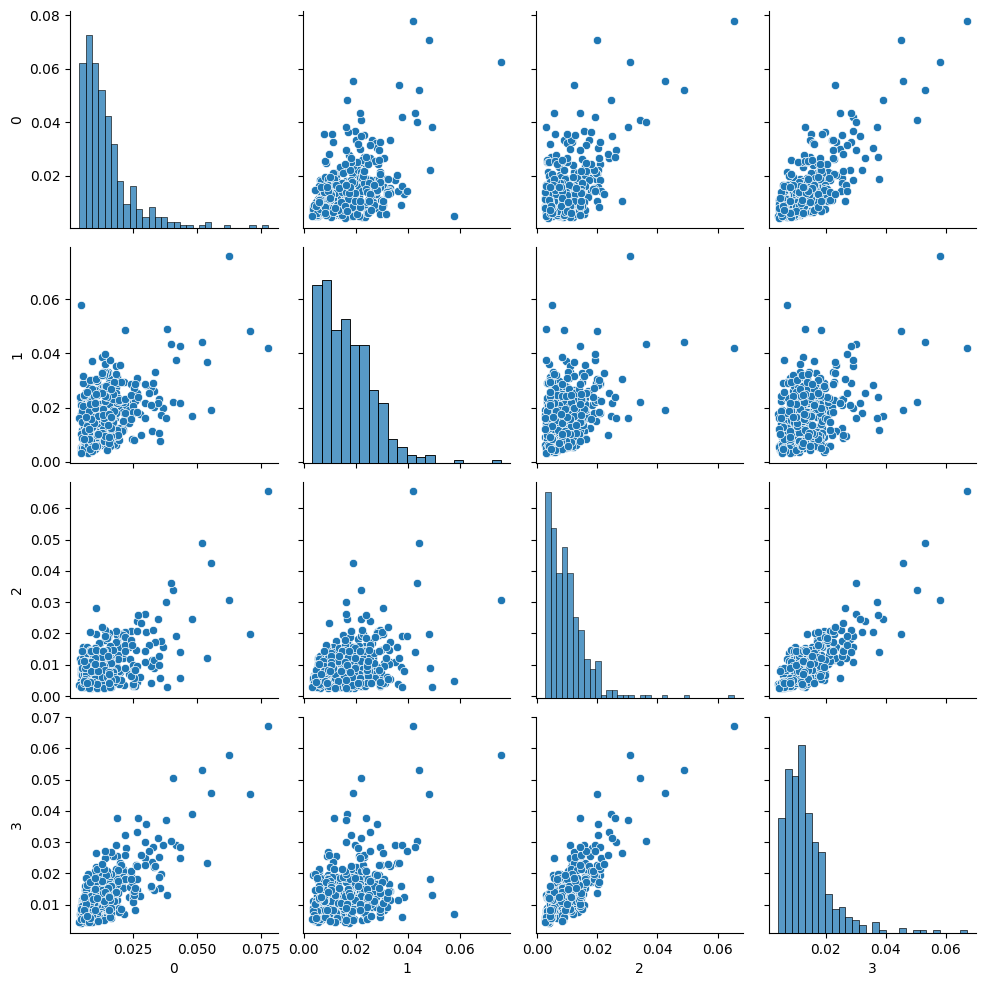

In [13]:
sns.pairplot(pd.DataFrame(sample_results))

In [14]:
pd.DataFrame(sample_results).to_csv("data/generated_results.csv")